# 6. Linear Model Selection and Regularisation – Labs

Excercises from **Chapter 6** of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

In [1031]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import ipywidgets as widgets

# Deps for pca/pcr
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from scipy import stats

## 8. In this exercise, we will generate simulated data, and will then use this data to perform best subset selection.

(a) Use the rnorm() function to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100.

In [54]:
np.random.seed(1)
x   = np.random.normal(0, 1, 100)
eps = eps = np.random.normal(0 ,1 , 100)

(b) Generate a response vector Y of length n = 100 according to the model $Y = β_0 +β_1 X +β_2 X^2 +β_3 X^3 +ε$ , where β0, β1, β2, and β3 are constants of your choice.


In [55]:
y_np = 2 + 2*x + 3*(x**2) + 2.5*(x**3) + eps

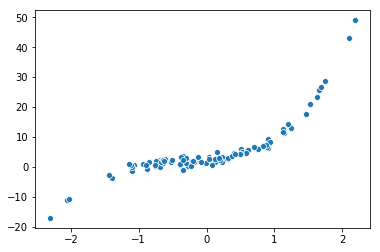

In [57]:
sns.scatterplot(x=x, y=y_np);

(c) Use the regsubsets() function to perform best subset selection in order to choose the best model containing the predictors X,X2,...,X10. What is the best model obtained according to Cp, BIC, and adjusted R2? Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained. Note you will need to use the data.frame() function to create a single data set containing both X and Y .

In [78]:
def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models accumulating Residual Sum of Squares (RSS)
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]


def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]

In [67]:
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
y = pd.DataFrame({'y': y_np})

# get all model results
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done
Progess: k = 7, done
Progess: k = 8, done
Progess: k = 9, done
Progess: k = 10, done


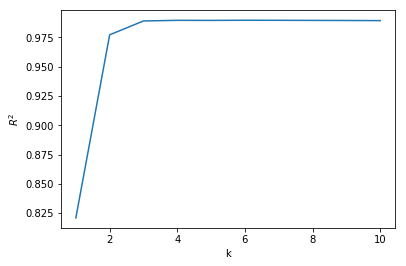

Model selected: 
Intercept    2.298519
X            2.659149
X2           2.617578
X5           2.279830
X7          -0.684882
X9           0.065720
X10          0.001195
dtype: float64


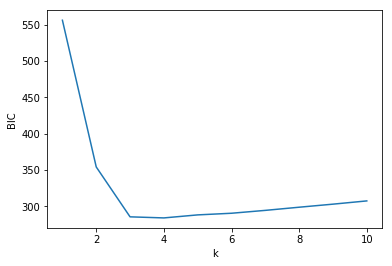

Model selected: 
Intercept    2.276949
X            1.910076
X2           2.657467
X3           2.605378
X6           0.020949
dtype: float64


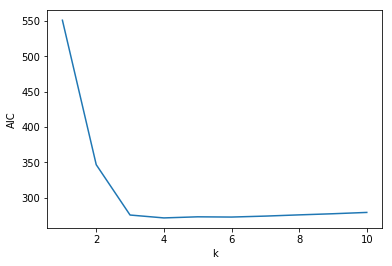

Model selected: 
Intercept    2.276949
X            1.910076
X2           2.657467
X3           2.605378
X6           0.020949
dtype: float64


In [146]:
# Get predictor count
k = np.arange(1, len(X.columns)+1)

# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))

# Plot best r-squared score for each subset
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('$R^2$')
plt.show()

# Select best subset
coefs_r2 = [(max_adjr2(m)[1].rsquared_adj, max_adjr2(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(max(coefs_r2)[1]))


# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))

# Get best BIC
bic = [min_bic(m)[1].bic for m in model_subsets]

sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

# Select best subset
coefs_bic = [(min_bic(m)[1].bic, min_bic(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(min(coefs_bic)[1]))


# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))

# Get best AIC
aic = [min_aic(m)[1].aic for m in model_subsets]

sns.lineplot(x=k, y=aic)
plt.xlabel('k')
plt.ylabel('AIC')
plt.show()

# Select best subset
coefs_aic = [(min_aic(m)[1].aic, min_aic(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(min(coefs_aic)[1]))


**Comment:** RSS chooses a model with too many features as expected due to overfitting. BIC and AIC try to compensate for overfitting, and do a reasonable job choosing a model with one superfluous feature.

### (d) Repeat (c), using forward stepwise selection and also using backwards stepwise selection. How does your answer compare to the results in (c)?

First set up some functions

In [222]:
def forward_stepwise(X, y, scorer='ssr', results=[(0, [])]):
    """Perform forward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.207)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds}).drop(0)
    
    # Get score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = '{} ~ {}'.format(y.columns[0], '+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r    += [(model, [p]+p_used)]
    
    # Choose predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 
                        
    new_results = results + [best_score]
    # Recursive call to self
    return forward_stepwise(X, y, scorer, new_results)

In [227]:
def backward_stepwise(X, y, scorer='ssr', results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = '{} ~ {}'.format(y.columns[0], '+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        if scorer == 'ssr':
            return backward_stepwise(X, y, scorer, [(model.ssr, p_all)])
        if scorer == 'rsquared_adj':
            return backward_stepwise(X, y, scorer, [(model.rsquared_adj, p_all)])
        if scorer == 'bic':
            return backward_stepwise(X, y, scorer, [(model.bic, p_all)])
        if scorer == 'aic':
            return backward_stepwise(X, y, scorer, [(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = '{} ~ {}'.format(y.columns[0], '+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model, p_test)]
    
    # Choose removal of predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 

    new_results = results + [best_score]
    # Recursive call to self
    return backward_stepwise(X, y, scorer, new_results)


def subset_analysis(df, scorer):
    """Renders results from forward_stepwise() and backward_stepwise()"""
    df['predictors_str'] = df['predictors'].astype(str)
    
    ax = sns.lineplot(x='predictors_str', y=scorer, data=df, sort=False)
    plt.xticks(rotation=90)
    plt.show();
    
    if scorer == 'rsquared_adj':
        display(df[df[scorer] ==  df[scorer].max()].drop('predictors_str', axis=1))
    else:
        display(df[df[scorer] ==  df[scorer].min()].drop('predictors_str', axis=1))

#### Forward stepwise selection

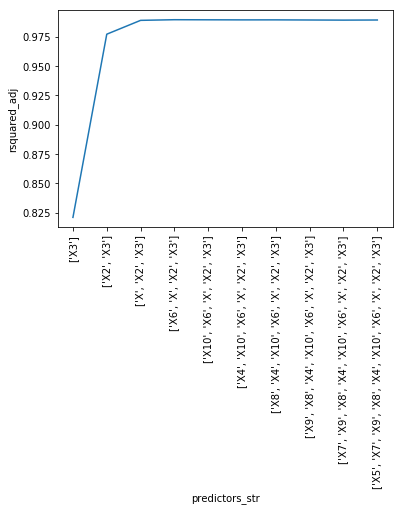

,rsquared_adj,predictors
4,0.989408,"[X6, X, X2, X3]"


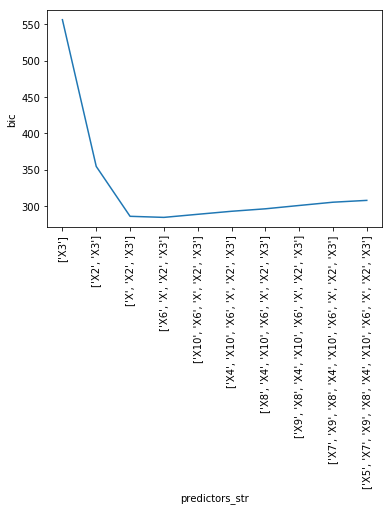

,bic,predictors
4,284.249198,"[X6, X, X2, X3]"


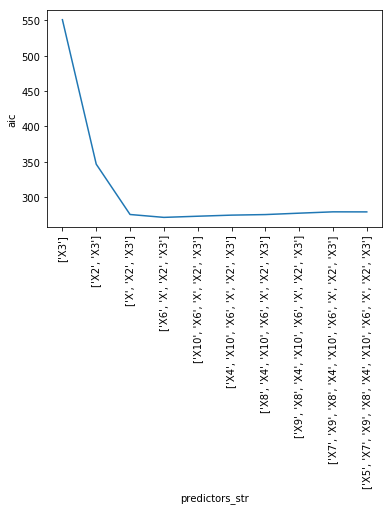

,aic,predictors
4,271.223347,"[X6, X, X2, X3]"


In [223]:
# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))
scorer = 'rsquared_adj'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))
scorer = 'bic'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))
scorer = 'aic'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

#### Backward stepwise selection

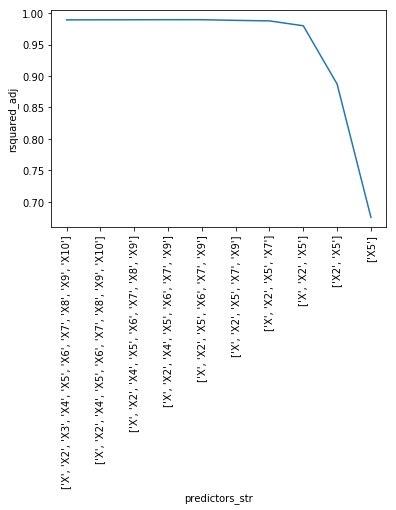

,rsquared_adj,predictors
3,0.989431,"[X, X2, X4, X5, X6, X7, X9]"


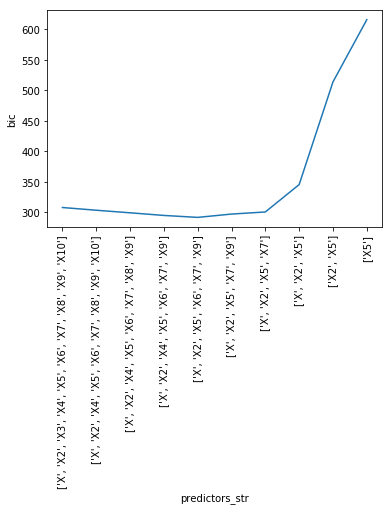

,bic,predictors
4,291.450514,"[X, X2, X5, X6, X7, X9]"


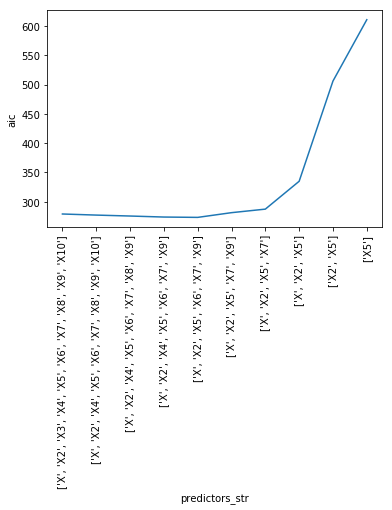

,aic,predictors
4,273.214322,"[X, X2, X5, X6, X7, X9]"


In [225]:
# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))
scorer = 'rsquared_adj'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))
scorer = 'bic'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))
scorer = 'aic'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

**Comment:**

Forward stepwise selection chooses the same models as best susbset selection for all metrics.

Backward stepwise selection tends to select overly complex models in this setting with 3-4 superfluous features depending on the metric used. 

**Revision note:** It seems somewhat down to chance as to which approach – forward or backward – will work best in a giving setting. In reality without simulation we won't have the luxury of knowing the true optimum, so how do we choose?

### (e) Now fit a lasso model to the simulated data, again using X,X2, . . . , X 10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.

In [344]:
def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size

def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=False, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs

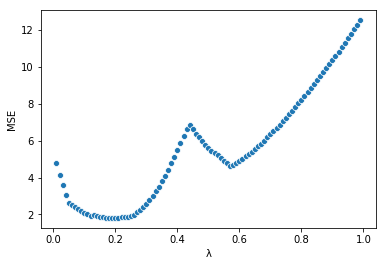

In [346]:
lambdas = np.arange(0.01, 1, 0.01)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [347]:
min(zip(MSEs, lambdas))

(1.8145436278960585, 0.19)

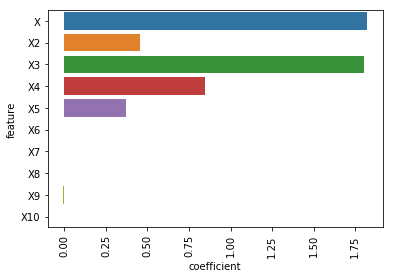

,feature,coefficient
0,X,1.823572
1,X2,0.454881
2,X3,1.802128
3,X4,0.847043
4,X5,0.373082
5,X6,0.000000
6,X7,0.000000
7,X8,-0.000000
8,X9,-0.009186
9,X10,-0.002988


In [348]:
lamb = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=lamb, fit_intercept=True, normalize=False, max_iter=1000000).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
# plot
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)
plt.show();
display(df)

Here the Lasso selects the correct features plus 4 superfluous paramaeters – 2 of which have ver low coeeficients.


#### Feature normalisation

It is possible to get a lower MSE by enabling sklearns feature normalisation as demonstrated below, different features are then selected.

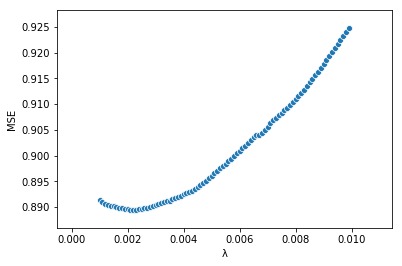

In [349]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs

lambdas = np.arange(0.001, 0.01, 0.0001)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [350]:
min(zip(MSEs, lambdas))

(0.8894063503790959, 0.0022000000000000006)

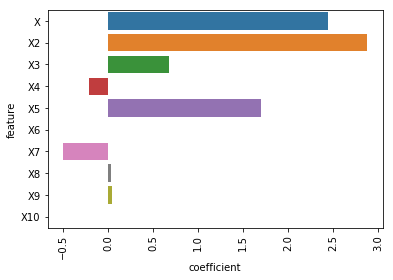

,feature,coefficient
0,X,2.446150
1,X2,2.876938
2,X3,0.678915
3,X4,-0.218099
4,X5,1.698335
5,X6,-0.000000
6,X7,-0.503101
7,X8,0.028357
8,X9,0.047248
9,X10,-0.003263


In [351]:
lamb = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=lamb, fit_intercept=True, normalize=False, max_iter=1000000).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
# plot
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)
plt.show();
display(df)

With feature normalisation the model selects 6 superfluous feautures, 3 with significant coefficients.

**Revision Notes:**

- is the effect of feature normalisation significant?
- if so, why does it have an effect?

### (f) Now generate a response vector Y according to the model $Y = β_0 + β_7 X^7 + ε$ , and perform best subset selection and the lasso. Discuss the results obtained.


#### Create simulated data

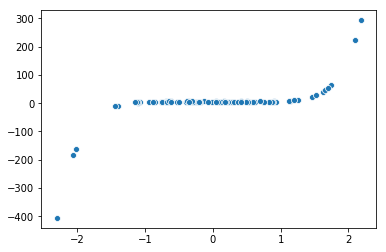

In [524]:
np.random.seed(1)
x   = np.random.normal(0, 1, 100)
eps = np.random.normal(0 ,1 , 100)

y_np = 5 + 1.2*(x**7) + eps

sns.scatterplot(x=x, y=y_np);

In [525]:
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
y = pd.DataFrame({'y': y_np})

#### Best subset selection

In [454]:
def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]


def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


# Intended API
# ----------------------------------------------

def best_subset(X, y, scorer='ssr'):
    """Perform best subset selection using Residual Sum of Squares to
    select best model in each subset.
    Notes: highly computationally expensive for large number of features in  X
    Maxes out my laptop for p > 14"""
    # get all model results
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))

    # Select best in each subset using chosen scorer
    if scorer == 'ssr':
        # Get best rss score for each subset
        return [min_rss(m) for m in model_subsets]
    elif scorer == 'rsquared_adj':
        # Get best rss score for each subset
        return [max_adjr2(m) for m in model_subsets]       
    elif scorer == 'bic':
        # Get best rss score for each subset
        return [min_bic(m) for m in model_subsets]
    elif scorer == 'aic':
        # Get best rss score for each subset
        return [min_aic(m) for m in model_subsets]

    
def cross_val(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return (MSEs, formula)

In [455]:
# get all model results
best_subset_models = best_subset(X, y, scorer='bic')

Best subset selected: k = 1/10, done
Best subset selected: k = 2/10, done
Best subset selected: k = 3/10, done
Best subset selected: k = 4/10, done
Best subset selected: k = 5/10, done
Best subset selected: k = 6/10, done
Best subset selected: k = 7/10, done
Best subset selected: k = 8/10, done
Best subset selected: k = 9/10, done
Best subset selected: k = 10/10, done


,formula,mse
2,y ~ X2 + X6 + X7,0.854173


Intercept    5.271801
X2          -0.320021
X6           0.020727
X7           1.203961
dtype: float64

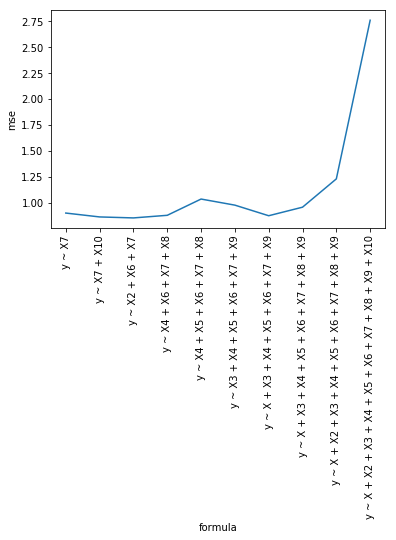

In [456]:
# Parse results
best_subset_formula = [f[0] for f in best_subset_models]
best_subset_mses    = [np.mean(cross_val(f, X, y, 10)[0]) for f in best_subset_formula]
df = pd.DataFrame({'formula': best_subset_formula, 'mse': best_subset_mses})

# Show chosen model
display(df[df['mse'] == df['mse'].min()])
best_subset_params = best_subset_models[2][1].params
display(best_subset_params)

# Plot mse across subsets
ax = sns.lineplot(x='formula', y='mse', data=df, sort=False)
plt.xticks(rotation=90)
plt.show();

Best subset selection with 10 fold cross validation selects a the model, y ~ X2 + X6 + X7 with a MSE of 0.854. 

Because this is simulated data we know that the true model is:

$f(x) = 5 + 1.2 x^7 + ε$

Best subset selection estimates the f(x) to be:

$f(x) = 5.27 - 0.32x^2 + 0.02x^6 + 1.20 x^7$

...which is pretty close. Let's plot on the same axis to see how close

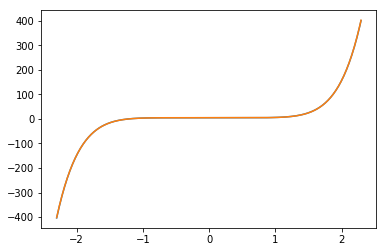

In [457]:
x = np.arange(-2.3, 2.3, 0.01)
sns.lineplot(x=x, y=5 + 1.2*(x**7))
sns.lineplot(x=x, y=5.27 - 0.32*(x**2) + 0.02*(x**6) + 1.20*(x**7));

Here we plot the actual values of y (blue) and the predicted values of y (orange) on the same axis. You can't see the actual line because th eprediction is so close.

#### The Lasso

In [526]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs


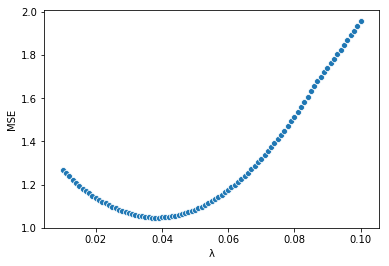

In [527]:
lambdas = np.arange(0.01, 0.1, 0.001)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [528]:
min(zip(MSEs, lambdas))

(1.0480683621470148, 0.03799999999999998)

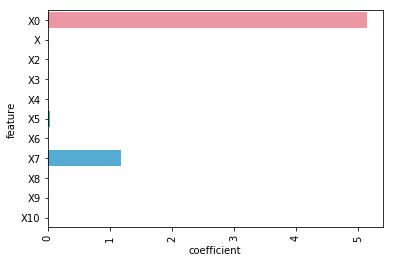

,feature,coefficient
0,X0,5.139609
1,X,0.000000
2,X2,-0.000000
3,X3,0.000000
4,X4,0.000000
5,X5,0.038360
6,X6,0.000000
7,X7,1.186933
8,X8,0.000000
9,X9,0.000000


In [529]:
# What coefficients does the lasso choose for the optimal lambda value?
λ = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X, y)
intercept  = pd.DataFrame({'feature': 'X0', 'coefficient': model.intercept_})
lasso_a_df = intercept.append(pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}), ignore_index=True)
ax = sns.barplot(x='coefficient', y='feature', data=lasso_a_df);
plt.xticks(rotation=90)
plt.show();

display(lasso_a_df)

Here the lasso selects almost the ideal model, with only one superfluous feature with a low coefficient. The MSE reported is marginally lower than for best subset selection at 1.048 compared to 0.854. 

Whilst searching for optimal value of lambda, I noticed another minima close to zero... deomonstrated below.

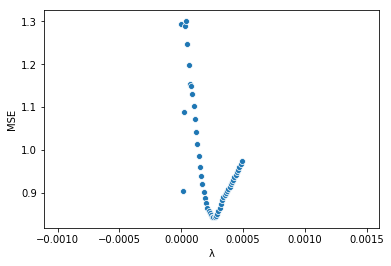

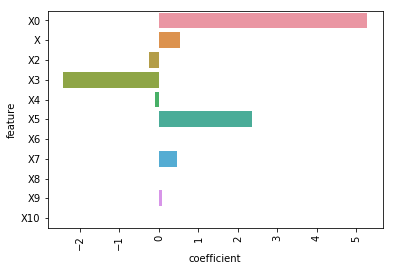

,feature,coefficient
0,X0,5.275241
1,X,0.546472
2,X2,-0.261390
3,X3,-2.428896
4,X4,-0.088259
5,X5,2.363543
6,X6,0.000000
7,X7,0.469777
8,X8,0.006829
9,X9,0.071042


In [531]:
lambdas = np.arange(0.000001, 0.0005, 0.00001)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
plt.show();

# What coefficients does the lasso choose for the optimal lambda value?
λ = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X, y)
intercept  = pd.DataFrame({'feature': 'X0', 'coefficient': model.intercept_})
lasso_b_df = intercept.append(pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}), ignore_index=True)
ax = sns.barplot(x='coefficient', y='feature', data=lasso_b_df);
plt.xticks(rotation=90)
plt.show();

display(lasso_b_df)

In [532]:
min(zip(MSEs, lambdas))

(0.8423025784930932, 0.00026100000000000006)

Here the value of lambda is very close to zero and so we expect it behave like ridge regression – indeed there is a low proportion of zero value coefficients. 

The MSE is now lower 0.842 than that achieved for both best subset selection and the first version of lasso.

#### But how do these various model estimates compare against the actual f(x)?

Because data is simulated, we can compare the selected models to the actual model


In [536]:
x   = np.random.normal(0, 1, 100)
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
X_np = np.insert(np.array(X), 0, 1, axis=1)

y_actual = 5 + 1.2*(x**7)
bss_params = np.zeros(11)
bss_params[0] = best_subset_params[0]
bss_params[2] = best_subset_params[1]
bss_params[6] = best_subset_params[2]
bss_params[7] = best_subset_params[3]

lasso_a_params = np.array(lasso_a_df['coefficient'])
lasso_b_params = np.array(lasso_b_df['coefficient'])

In [542]:
y_bss     = X_np @ bss_params
y_lasso_a = X_np @ lasso_a_params
y_lasso_b = X_np @ lasso_b_params

In [554]:
def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size

In [567]:
display(HTML('<h4>Actual MSEs compared to known f(x)</h4>'))
print('Best subset selection    : {}'.format(mse(y_bss, y_actual)))
print('Lasso a (higher lambda)  : {}'.format(mse(y_lasso_a, y_actual)))
print('Lasso b (lower lambda ~0): {}'.format(mse(y_lasso_b, y_actual)))

Best subset selection    : 0.5015558203750072
Lasso a (higher lambda)  : 0.2332802506985821
Lasso b (lower lambda ~0): 5.483599366482682


Here we used three seperate approaches to estimate the mode f(x) in a simulated context with noise added. We tested the estimated model for each aproach against the true f(x) without noise.

Best subset selection and ridge-regression (lasso b) produced the lowest CV mse, but lasso a achieved the lowest MSE when compared with the true model f(x). The lasso a was also most effective at ignoring superfluous feautures.

It seems that lasso_a performed best because it ignored irrelavant features and so minimised overfitting. The cross-validation CV was not able to account for this advantage.

## 9. In this exercise, we will predict the number of applications received using the other variables in the College data set.

(a) Split the data set into a training set and a test set.

In [1078]:
college_df = pd.read_csv('./data/College.csv')

# 8(b) label rows by college
college_df = college_df.set_index(['Unnamed: 0'], append=True, verify_integrity=True)
college_df.rename_axis([None, 'College'], inplace=True)

# Get dummimies
college_df = pd.get_dummies(college_df).drop('Private_No', axis=1)

# Convert to floats
college_df = college_df.astype(np.float64)

# Remove fullstops from col names
college_df = college_df.rename(index=str, columns={"F.Undergrad": "F_Undergrad", 
                                                   "P.Undergrad": "P_Undergrad",
                                                   "S.F.Ratio": "S_F_Ratio",
                                                   "perc.alumni": "perc_alumni",
                                                   "Grad.Rate": "Grad_Rate",
                                                   "Room.Board": "Room_Board"})

# Assign train and test sets
np.random.seed(1)
train = np.random.rand(len(college_df)) < 0.5
response   = 'Apps'
X_train = college_df[train].drop(response, axis=1)
X_test  = college_df[~train].drop(response, axis=1)
y_train = college_df[train][response]
y_test  = college_df[~train][response]


display(X_train.head())

,,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate,Private_Yes
,College,,,,,,,,,,,,,,,,,
0,Abilene Christian University,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,3300.0,450.0,2200.0,70.0,78.0,18.1,12.0,7041.0,60.0,1.0
2,Adrian College,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,3750.0,400.0,1165.0,53.0,66.0,12.9,30.0,8735.0,54.0,1.0
3,Agnes Scott College,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,5450.0,450.0,875.0,92.0,97.0,7.7,37.0,19016.0,59.0,1.0
4,Alaska Pacific University,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,4120.0,800.0,1500.0,76.0,72.0,11.9,2.0,10922.0,15.0,1.0
5,Albertson College,479.0,158.0,38.0,62.0,678.0,41.0,13500.0,3335.0,500.0,675.0,67.0,73.0,9.4,11.0,9727.0,55.0,1.0


### (b) Fit a linear model using least squares on the training set, and report the test error obtained.

In [1079]:
# OLS
# Use all available features
f = '{} ~ {}'.format(response, '+'.join(X_train.columns))

# Fit model
model = smf.ols(formula=f, data=pd.concat([X_train, y_train], axis=1)).fit()
y_hat = model.predict(X_test)
print('RMSE: {}'.format(np.sqrt(mse(y_hat, y_test))))

RMSE: 1229.1326212399779


### (c) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

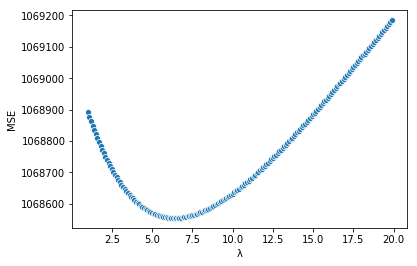

RMSE CV: 1033.7092919308884
@Lambda: 6.400000000000005


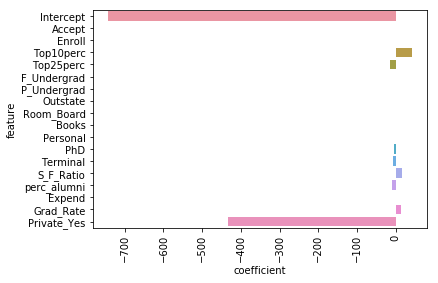

,feature,coefficient
0,Intercept,-743.853899
1,Accept,1.239709
2,Enroll,0.289301
3,Top10perc,42.248928
4,Top25perc,-14.340634
5,F_Undergrad,-0.015648
6,P_Undergrad,0.057172
7,Outstate,-0.052587
8,Room_Board,0.139781
9,Books,-0.190414


In [726]:
# Perform 10 fold cross validation to find optimal λ

def ridge_cv(X, y, λ, k):
    """Perform ridge regresion with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Ridge(alpha=λ, fit_intercept=True, normalize=False, solver='cholesky')
        m = model.fit(X_train, y_train)
        
        # Measure MSE
        y_hat = m.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

def optimise(X, y, cv, lambdas):
    MSEs = [] 
    for l in lambdas:
        MSEs += [np.mean(cv(X, y, λ=l, k=10))]
    
    sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
    plt.show();
    
    lamb = min(zip(MSEs, lambdas))
    print('RMSE CV: {}\n@Lambda: {}'.format(np.sqrt(lamb[0]), lamb[1]))

    # What coefficients does ridge regression choose for the optimal lambda value?
    model = model = linear_model.Ridge(alpha=λ, fit_intercept=True, normalize=False, solver='cholesky')
    m = model.fit(X, y)
    
    intercept = pd.DataFrame({'feature': 'Intercept', 'coefficient': [m.intercept_]})
    ridge_df  = intercept.append(pd.DataFrame({'feature': X.columns, 'coefficient': m.coef_}), ignore_index=True)
    
    ax = sns.barplot(x='coefficient', y='feature', data=ridge_df)
    plt.xticks(rotation=90)
    plt.show();
    
    display(ridge_df)
    return lamb[1]

     
opt_lamb = optimise(X_train, y_train, ridge_cv, np.arange(1, 20, .1))

In [727]:
# Use optimal lambda value optained in previous step, then test model on test set.
model = model = linear_model.Ridge(alpha=opt_lamb, fit_intercept=True, normalize=False, solver='cholesky')
# Fit on full training setl
model.fit(X_train, y_train)
# Get test rmse
y_hat = model.predict(X_test)
print('RMSE Test: {}'.format(np.sqrt(mse(y_hat, y_test))))

RMSE Test: 1230.2863913806934


**Comment:** With an RSME on the test set of 1230.29, ridge regression performs marginally worse than a naive linear regression with all feature (RMSE: 1229.13).

### (d) Fit a lasso model on the training set, with λ chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates.

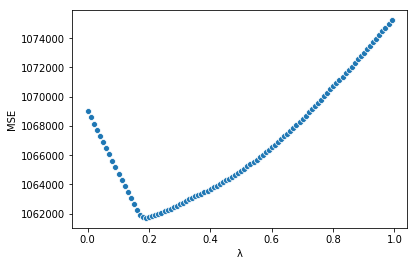

RMSE CV: 1030.3953270677766
@Lambda: 0.19099999999999998


In [765]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, copy_X=True, fit_intercept=True, max_iter=10000,
                                   normalize=True, positive=False, precompute=False, random_state=None,
                                   selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

lambdas = np.arange(.001, 1, .01)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X_train, y_train, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
plt.show();

lamb = min(zip(MSEs, lambdas))
print('RMSE CV: {}\n@Lambda: {}'.format(np.sqrt(lamb[0]), lamb[1]))

In [801]:
def lasso_test(λ):
    # Fit model on full training set with optimal lambda
    model = linear_model.Lasso(alpha=λ, copy_X=True, fit_intercept=True, max_iter=10000,
                               normalize=True, positive=False, precompute=False, random_state=None,
                               selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
    
    # Get test rmse
    y_hat = model.predict(X_test)
    print('RMSE Test: {}'.format(np.sqrt(mse(y_hat, y_test))))
    
    # # What coefficients does the lasso choose for the optimal lambda value?
    intercept = pd.DataFrame({'feature': 'Intercept', 'coefficient': [model.intercept_]})
    lasso_df  = intercept.append(pd.DataFrame({'feature': X_train.columns, 'coefficient': model.coef_}), ignore_index=True)
    
    ax = sns.barplot(x='coefficient', y='feature', data=lasso_df);
    plt.xticks(rotation=90)
    plt.show();
    
    display(lasso_df)

interact(lasso_test, λ=widgets.FloatSlider(min=lamb[1]/100, max=lamb[1]*10, step=0.01, value=lamb[1]));


interactive(children=(FloatSlider(value=0.19099999999999998, description='λ', max=1.9099999999999997, min=0.00…

### Results so far...


| Model | RSME test |
| --- | --- |
| Lasso          | 1228.58 |
| OLS | 1229.13 |
| Ridge          | 1230.29 |

### (e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.

In [894]:
def pcr_cv(seed, cv_folds):
    """Perform Principle Component Regression evaluated with
    k-fold cross validation"""

    # Select components with cross-validation
    # ---------------------------------------
    # Load data
    X = college_df[train].drop(response, axis=1)
    y = college_df[train][response]
    
    # Get all principle components
    pca = PCA()
    X_reduced = pca.fit_transform(scale(X))
    
    # Get cv MSE for cumulative components
    M = X_reduced.shape[1]
    MSEs = []
    for m in range(M):
        model = LinearRegression()
        cv    = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        cv10  = cross_val_score(model, X_reduced[:, 0:m+1], y, cv=cv, scoring='neg_mean_squared_error')
        MSEs += [np.mean(np.abs(cv10))]
        
    df = pd.DataFrame({'principal components count': np.arange(1, M+1), 'RMSE_CV': np.sqrt(MSEs)})
    ax = sns.lineplot(x='principal components count', y='RMSE_CV', data=df)
    plt.show();
    #ax.axes.set_ylim(100000, 140000)

    # Make Test predictions
    # ---------------------------------------
    
    # Get optimal number of compoenents from cv results
    m = df[df['RMSE_CV'] == df['RMSE_CV'].min()]['principal components count'].iloc[0]
    
    # Get all principle components across train and test values for X
    X_reduced = pca.fit_transform(scale(college_df.drop(response, axis=1)))
    
    # Fit model on TRAINING subset of PCs
    model = LinearRegression()
    model.fit(X_reduced[train][:, 0:m+1], y_train)
    # Predict using TEST subset of PCs
    y_hat = model.predict(X_reduced[~train][:, 0:m+1])
    
    # Show results for optimal number of components
    best_df = df[df['RMSE_CV'] == df['RMSE_CV'].min()]
    best_df['RSME_Test'] = np.sqrt(mse(y_hat, y_test))
    display(best_df)
    
    print(model.score(X_reduced[~train][:, 0:m+1], y_test))
    

interact(pcr_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), IntSlider(value=10, description=…

### Results so far...


| Model | RSME test |
| --- | --- |
| Lasso          | 1228.58 |
| OLS | 1229.13 |
| PCR | 1229.13 |
| Ridge          | 1230.29 |

### (f) Fit a PLS model on the training set, with M chosen by cross- validation. Report the test error obtained, along with the value of M selected by cross-validation.

In [974]:
from sklearn.cross_decomposition import PLSRegression

def pls_cv(seed, cv_folds):
    """Perform Partial Least Squares Regression evaluated with
    k-fold cross validation"""

    # Select components with cross-validation
    # ---------------------------------------
    # Load test data
    X_train = np.array(college_df[train].drop(response, axis=1))
    y_train = np.array(college_df[train][response])   
    X_test  = np.array(college_df[~train].drop(response, axis=1))
    y_test  = np.array(college_df[~train][response])
    
    # Get cv MSE for cumulative components
    M = X_train.shape[1]
    MSEs = []
    for m in range(M):
        cv      = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        results = cross_val_score(PLSRegression(n_components=m+1, scale=True, max_iter=10000), 
                                  X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        MSEs   += [np.mean(np.abs(results))]
        
    df = pd.DataFrame({'principal components count': np.arange(1, M+1), 'RMSE_CV': np.sqrt(MSEs)})
    ax = sns.lineplot(x='principal components count', y='RMSE_CV', data=df)
    plt.show();
    
    # Make Test predictions
    # ---------------------------------------
    # Get optimal number of components from cv results
    m = df[df['RMSE_CV'] == df['RMSE_CV'].min()]['principal components count'].iloc[0]
    print(m)

    # Fit model on TRAINING subset of PCs
    model = PLSRegression(n_components=m, scale=True, max_iter=10000).fit(X_train, y_train)
    # Predict using TEST subset of PCs
    X_test_r, y_test_r = model.transform(X_test, y_test)
    y_hat = model.predict(X_test)
    
    # Show results for optimal number of components
    best_df = df[df['RMSE_CV'] == df['RMSE_CV'].min()]
    best_df['RSME_Test'] = np.sqrt(mse(y_hat.T[0], y_test))
    display(best_df)

    
interact(pls_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), IntSlider(value=10, description=…

### Results so far...


| Model | RSME test |
| --- | --- |
| Lasso          | 1228.58 |
| OLS | 1229.13 |
| PCR | 1229.13 |
| Ridge          | 1230.29 |
| PLS          | 1230.36 |

### Personal Q: how does backward stepwise selection compare with these results?

In [1083]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

X_train = college_df[train].drop(response, axis=1)
X_test  = college_df[~train].drop(response, axis=1)
y_train = pd.DataFrame({'Apps': college_df[train][response]})
y_test  = np.array(college_df[~train][response])

estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=10, scoring='neg_mean_squared_error')

selector = selector.fit(X_train, y_train)

y_hat = selector.predict(X_test)
print('RMSE: {}'.format(np.sqrt(mse(y_hat, y_test))))

RSME: 1228.098002318284


### (g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

In [1084]:
# Functions to emulate R's lm().plot() functionality
# Providing powerful residual plots for simple AND multivariate
# linear regresssion
# - bring your own predictions
# - underlying stats available as pandas dataframe
# - visualise linearity and outliers in multiple dimensions


def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = H.diagonal()
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 18))
    
    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');

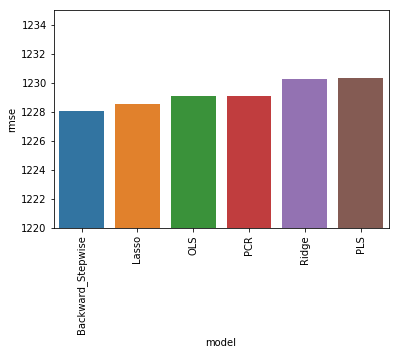

,model,rmse
0,Backward_Stepwise,1228.10
1,Lasso,1228.58
2,OLS,1229.13
3,PCR,1229.13
4,Ridge,1230.29
5,PLS,1230.36


In [1090]:
models = ['Backward_Stepwise', 'Lasso', 'OLS', 'PCR', 'Ridge', 'PLS']
rmses  = [1228.10, 1228.58, 1229.13, 1229.13, 1230.29, 1230.36]
results = pd.DataFrame({'model': models, 'rmse': rmses})

ax = sns.barplot(x='model', y='rmse', data=results)
ax.set_ylim([1220,1235])
plt.xticks(rotation=90)
plt.show();

display(results)

In [1086]:
college_df['Apps'].mean()

3001.6383526383524

**Comment:** 

The mean number of applications received across all colleges is 3002. Our best models predictions yield a means error of +/- 1228 applications. So for the average college we would expect our prediction to be in error by +/- 1228/3002 = 40.9%.

All models return RMSE scores in the range 1228.10 (backward stepwise) - 1230.36 (Partial Least SQuares). Thats a disparity of ...

In [1093]:
((1230.36 - 1228.10) / 1230.36) *100

0.18368607562014297

... 0.18%, so there really isn't much between them in this setting.

Let's take a look at the diagnostics for the best model found by backward stepwise selection...

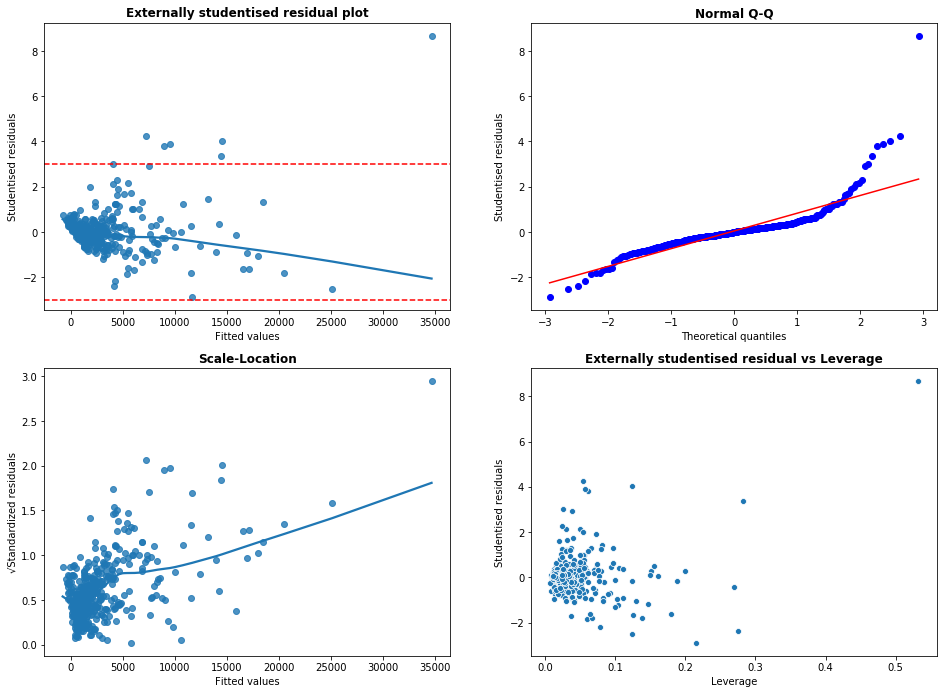

In [1087]:
# Diagnostics for bacward stepwise model
lm_plot(lm_stats(X_test, y_test, y_hat))

We immediately see a very high leverage outlier. There's some none normal distributions, some heteroscedaticity and some no non-linear relationships.

Below we take logs of reponse and predictors.

RSME: 1085.4596006988925


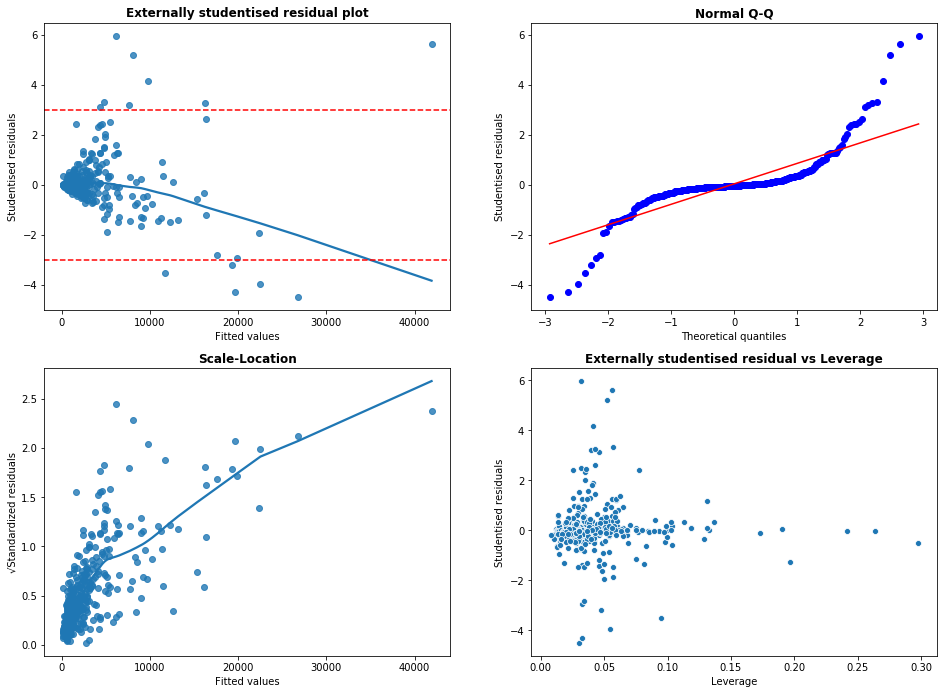

In [1095]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

X_train = college_df[train].drop(response, axis=1)
X_test  = college_df[~train].drop(response, axis=1)
y_train = pd.DataFrame({'Apps': college_df[train][response]})
y_test  = np.array(college_df[~train][response])

estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=10, scoring='neg_mean_squared_error')

selector = selector.fit(np.log1p(X_train), np.log(y_train))

y_hat = np.exp(selector.predict(np.log1p(X_test)))
print('RSME: {}'.format(np.sqrt(mse(y_hat, y_test))))

# Diagnostics for bacward stepwise model
lm_plot(lm_stats(np.log1p(X_test), y_test, y_hat))

This yields a significantly improved RMSE from 1228.10 down to 1085.46. 

The leverage of the anomalous observations is reduced. Non-normal distirbution of predictors is more clearly pronounced.

Non-linear realtionships and heteroscedaticity not accounted for by our model remain suggesting non-linear models might be of benefit here.